## Loading the data

In [1]:
import os, urllib, tarfile

os.chdir("..")
print(os.getcwd())

C:\Users\vlcan\Machine_learning_python\Housing prices predictor


In [2]:
dataset_url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
dataset_path = "dataset\housing"

In [3]:
if not os.path.isdir(dataset_path):
    os.makedirs(dataset_path)
    
tgz_path = dataset_path + "\housing.tgz"
urllib.request.urlretrieve(dataset_url, tgz_path)

('dataset\\housing\\housing.tgz', <http.client.HTTPMessage at 0x1c1d14395b0>)

In [4]:
housing_tgz = tarfile.open(tgz_path)
housing_tgz.extractall(path=dataset_path)
housing_tgz.close()

## Building the dataframe (analyzing the data)

In [5]:
import pandas

In [6]:
dataset_filepath = dataset_path + '\housing.csv'

df = pandas.read_csv(dataset_filepath)
df = df.reset_index() # Creates an index column (useful for later)
df.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


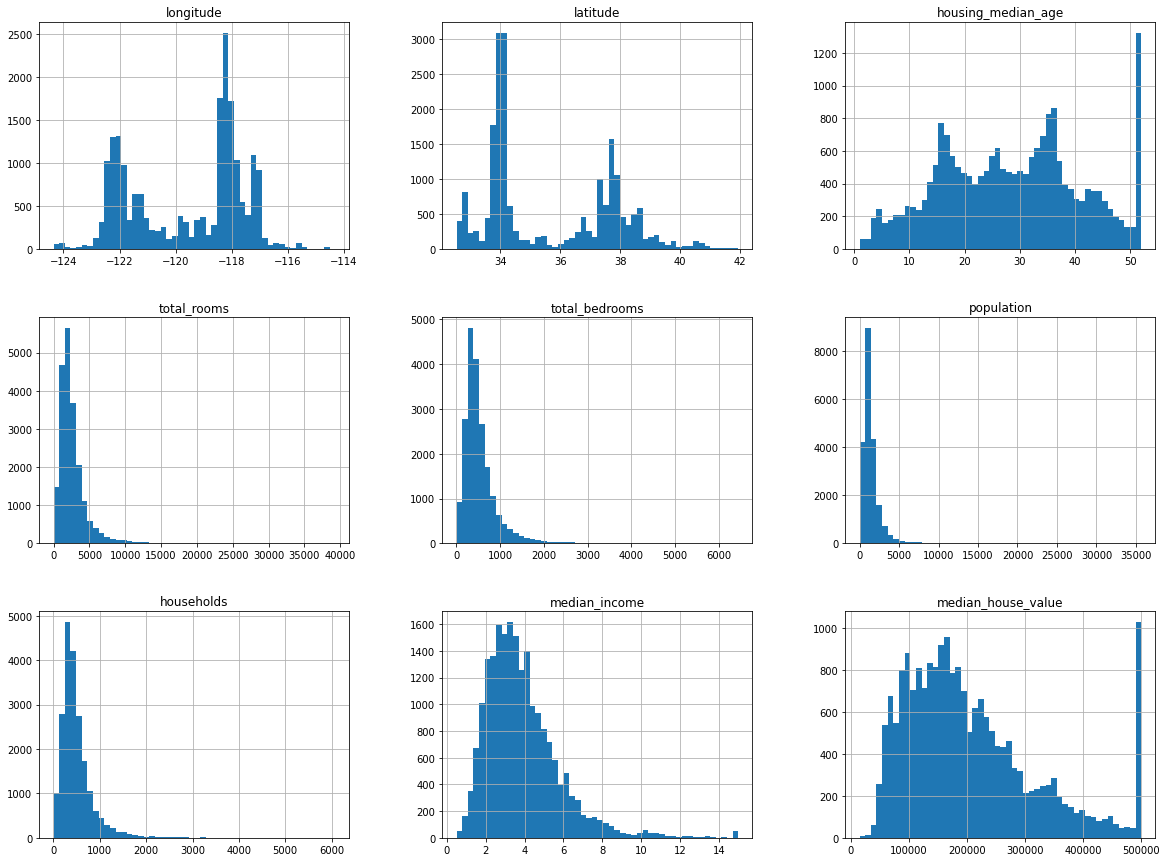

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt 

df.iloc[:, 1:].hist(bins = 50, figsize = (20,15)) # the iloc ignores the index column
plt.show()

## Separating the data set (train set + test set)

In [8]:
import numpy as np

In [9]:
### DATA SEPARATOR FOR DYNAMIC DATASETS (useful for "online" learning)

from zlib import crc32

def test_set_check(identifier, test_ratio): 
    # hash_function that checks if a piece of data should belong in the test set
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32 

def split_train_test_by_id(data, test_ratio, id_column): 
    ids = data[id_column] 
    in_test_set = ids.apply(lambda id_: test_set_check( id_, test_ratio)) 
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
train_set, test_set = split_train_test_by_id(df, 0.2, "index")
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [134]:
### DATA SEPARATOR FOR BATCH LEARNING (the sets will be different deppending on the initial dataset)

from sklearn.model_selection import StratifiedShuffleSplit

df["income_cat"] = pandas.cut(df["median_income"], 
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                              labels=[1, 2, 3, 4, 5])

separator = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # STRATIFIED (not random): reduces biasing

In [12]:
for train_index, test_index in separator.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
strat_train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


# Visualizing features

In [13]:
housing = strat_train_set.copy()
housing.drop("index", axis=1, inplace=True)

### Locational influence

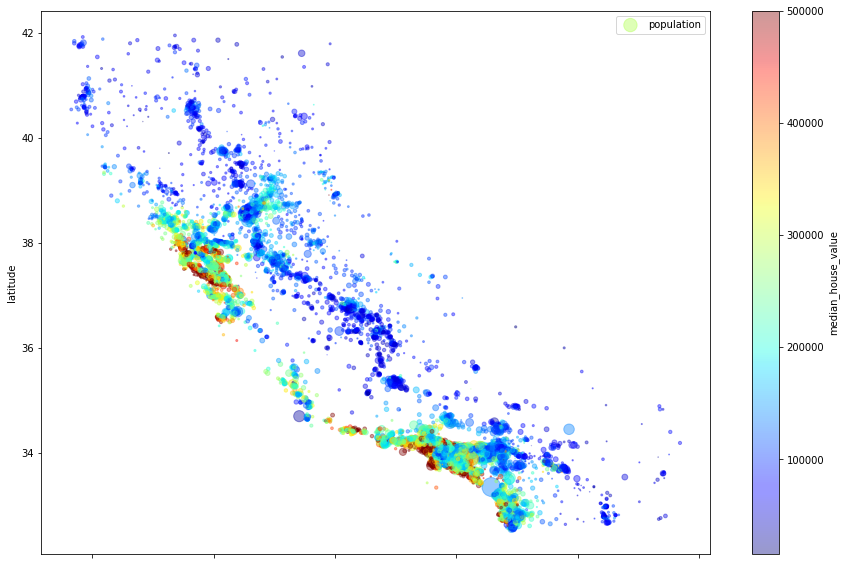

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4, 
             s=housing["population"]/100, label="population", figsize=(15,10), 
             c="median_house_value", cmap = plt.get_cmap("jet"), colorbar = True) 

plt.legend()

#### (The houses in the most clustered areas that are closer to the coast tend to be more expensive)

### Linear Correlation

In [15]:
### LINEAR CORRELATION

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

#### (Current most important parameters: median income, latitude, total rooms and house median age)

In [16]:
### LINEAR CORRELATION BETWEEN CREATED PARAMETERS: (bedrooms_per_room, rooms_per_household, population_per_household)

housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"] # Useful
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"] # Useful
housing["population_per_household"] = housing["population"] / housing["households"] # Not useful

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

#### (Current most important parameters: median income, BEDROOMS PER ROOM, ROOMS PER HOUSEHOLD and latitude)

# Preparing the data - Detailed view

In [17]:
housing = strat_train_set.drop(["median_house_value", "index"], axis=1)       # Train set
housing_labels = strat_train_set["median_house_value"].copy()                 # Train set labels

housing_numerical = housing.drop("ocean_proximity", axis=1)                   # Isolate numerical values for certain operations

In [18]:
### CREATING TRANSFORMER: ATTRIBUTES ADDER

from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c) for c in col_names]


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, use_population_per_household=False):
        self.use_population_per_household = use_population_per_household
        
    def fit(self, X, y=None):
        # X represents the dataset's parameter values; y represents the dataset's labels
        # However, neither of those are used. This transformer doesn't need to learn from
        # data (unlike the SimpleInputer(strategy="mean"))  
        
        return self          
    
    def transform(self, X):
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        
        if self.use_population_per_household:
            population_per_household = X[:, population_ix] / X[:, households_ix]
            return np.c_[X, bedrooms_per_room, rooms_per_household, population_per_household]
        
        return np.c_[X, bedrooms_per_room, rooms_per_household]

### Filling in the gaps

In [19]:
housing.info()
housing.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


#### (Certain columns are incomplete - SOLUTION: fill unspecified values with the median value)

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

#imputer.fit(housing_numerical)                                                 # FIT +
#housing_numerical_complete_array = imputer.transform(housing_numerical)        # TRANSFORM

housing_numerical_tf_array = imputer.fit_transform(housing_numerical)

type(housing_numerical_tf_array)

numpy.ndarray

In [21]:
housing_tf = pandas.DataFrame(housing_numerical_tf_array, 
                              columns=housing_numerical.columns,
                              index=housing_numerical.index)

housing_tf["ocean_proximity"] = housing["ocean_proximity"]

housing_tf.info()
housing_tf.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


### Adding combo attributes

In [22]:
attr_adder = CombinedAttributesAdder(use_population_per_household=False)
housing_combo_array = attr_adder.transform(housing_tf.values)

if attr_adder.use_population_per_household:
    column_tuple = (np.array(housing_tf.columns), np.array(["BpR", "RpH", "PpH"]))
else:
    column_tuple = (np.array(housing_tf.columns), np.array(["BpR", "RpH"]))

housing_combo = pandas.DataFrame(housing_combo_array,
                                 columns=np.hstack(column_tuple),
                                 index=housing_tf.index)

housing_combo.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,BpR,RpH
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,0.223852,4.625369
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,0.159057,6.00885
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,0.241291,4.225108
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,0.200866,5.232295
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,0.231341,4.50581


### Encoding text into numbers

In [101]:
### TRANSFORMING TEXT PARAMETERS INTO BOOLEAN (one-hot encoding)

from sklearn.preprocessing import OneHotEncoder

text_encoder = OneHotEncoder()

two_d_array = housing["ocean_proximity"].values.reshape(-1, 1)
housing_bool_column_spmtx = text_encoder.fit_transform(two_d_array)

housing_bool_column_spmtx

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [102]:
housing_bool = housing_combo.drop("ocean_proximity", axis=1)
housing_bool_column_array = housing_bool_column_spmtx.toarray()

for i in range(5):
    housing_bool[text_encoder.categories_[0][i]] = housing_bool_column_array[:, i]
    
housing_bool.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,BpR,RpH,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,0.223852,4.625369,1.0,0.0,0.0,0.0,0.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,0.159057,6.00885,1.0,0.0,0.0,0.0,0.0
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,0.241291,4.225108,0.0,0.0,0.0,0.0,1.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,0.200866,5.232295,0.0,1.0,0.0,0.0,0.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,0.231341,4.50581,1.0,0.0,0.0,0.0,0.0


# Preparing the data - doing everything in pipelines

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # for standardization (division by the standard deviation*)

# * every attribute has a 1:1 correspondance in terms of variance (they all have the same unit)

num_pipeline = Pipeline([
                   ('imputer', SimpleImputer(strategy="median")), 
                   ('attribs_adder', CombinedAttributesAdder(use_population_per_household=False)), 
                   ('std_scaler', StandardScaler())
               ]) 

housing_num_tr = num_pipeline.fit_transform(housing_numerical)

pandas.DataFrame(housing_num_tr)

,0,1,2,3,4,5,6,7,8,9
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,0.155318,-0.312055
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,-0.836289,0.217683
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,0.422200,-0.465315
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.196453,-0.079661
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,0.269928,-0.357834
...,...,...,...,...,...,...,...,...,...,...
16507,0.722267,-0.673331,1.379547,-0.632123,-0.725361,-0.759010,-0.764049,0.554158,-0.428853,0.234352
16508,1.007011,-0.823004,0.902385,-0.667196,-0.584183,-0.329664,-0.636291,-0.948815,0.491503,-0.308114
16509,1.586489,-0.724781,-1.562952,1.043901,0.822735,0.607904,0.713156,-0.316705,-0.521776,0.346934
16510,0.782213,-0.851068,0.186642,-0.309919,-0.374849,-0.057178,-0.375451,0.098121,-0.303407,0.024995


In [86]:
from sklearn.compose import ColumnTransformer

numerical_attributes = list(housing_numerical)  # list(pd.df) returns the names of the df columns in a list
categorical_attributes = ["ocean_proximity"]    # string (which is a categorical attribute) that needs to be converted into bool

full_pipeline = ColumnTransformer([
                    ("num", num_pipeline, numerical_attributes), 
                    ("cat", OneHotEncoder(), categorical_attributes)
                ])

housing_prepared = full_pipeline.fit_transform(housing)  # on the full train set: the full_pipeline condenses every operation

pandas.DataFrame(housing_prepared)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,0.155318,-0.312055,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,-0.836289,0.217683,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,0.422200,-0.465315,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.196453,-0.079661,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,0.269928,-0.357834,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.722267,-0.673331,1.379547,-0.632123,-0.725361,-0.759010,-0.764049,0.554158,-0.428853,0.234352,0.0,1.0,0.0,0.0,0.0
16508,1.007011,-0.823004,0.902385,-0.667196,-0.584183,-0.329664,-0.636291,-0.948815,0.491503,-0.308114,0.0,1.0,0.0,0.0,0.0
16509,1.586489,-0.724781,-1.562952,1.043901,0.822735,0.607904,0.713156,-0.316705,-0.521776,0.346934,0.0,1.0,0.0,0.0,0.0
16510,0.782213,-0.851068,0.186642,-0.309919,-0.374849,-0.057178,-0.375451,0.098121,-0.303407,0.024995,1.0,0.0,0.0,0.0,0.0


# Building models

In [58]:
from sklearn.metrics import mean_squared_error

sample_data = housing.iloc[:5]  # data from "original" train set
corresponding_labels = housing_labels.iloc[:5]

sample_data_prepared = full_pipeline.transform(sample_data)  
# (the same model used in housing to make housing_prepared
# is being used in sample_data to make sample_data_prepared)

### Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [60]:
#-----evaluating-----#

lin_predictions = lin_reg.predict(sample_data_prepared)
lin_predictions_list = [float("{:.1f}".format(i)) for i in lin_predictions] 

print("Prediction:   ", lin_predictions_list)
print("Actual labels:", list(corresponding_labels))

lin_model_mse = mean_squared_error(corresponding_labels, lin_predictions)
lin_model_rmse = np.sqrt(lin_model_mse)

print("\nRMSE:", lin_model_rmse)

Prediction:    [210528.0, 317824.0, 210815.8, 59307.5, 189946.8]
Actual labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]

RMSE: 46552.454469164804


#### (Problem with lin_reg model: underfitting, underscoring even in the train set)

### Decision Tree Regressor

In [57]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [61]:
#-----evaluating-----#

tree_predictions = tree_reg.predict(sample_data_prepared)
tree_predictions_list = [float("{:.1f}".format(i)) for i in tree_predictions] 

print("Prediction:   ", tree_predictions_list)
print("Actual labels:", list(corresponding_labels))

tree_model_mse = mean_squared_error(corresponding_labels, tree_predictions)
tree_model_rmse = np.sqrt(tree_model_mse)

print("\nRMSE:", tree_model_rmse)

Prediction:    [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
Actual labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]

RMSE: 0.0


#### (Possible problem with tree_reg model: overfitting - it scored perfectly!!!)

### Creating validation sets

In [74]:
from sklearn.model_selection import cross_val_score  # K-fold cross-validation: generates K validation sets

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring = "neg_mean_squared_error", cv = 10) 

tree_rmse = np.sqrt(-scores)  # Scoring was done using a method that returns negative outputs

print("MRMSE:", tree_rmse.mean())  # mean of all of the K scores computed with the validation sets
print("\nStantdard deviation:", tree_rmse.std())

MRMSE: 70185.52553970915

Stantdard deviation: 2268.4237744386455


#### Conclusion: Overfitting did happen. This model would perform even worse than the lin_reg one

In [75]:
#-----evaluating-lin_reg-with-cross-validation-----#

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                         scoring = "neg_mean_squared_error", cv = 10) 

lin_rmse = np.sqrt(-scores)

print("MRMSE:", lin_rmse.mean())
print("\nStantdard deviation:", lin_rmse.std())

MRMSE: 68971.74228283842

Stantdard deviation: 2629.3909215694766


### Random Forest Regressor

In [87]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [88]:
#-----evaluating-forest_reg-with-cross-validation-----#

scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                         scoring = "neg_mean_squared_error", cv = 10) 

forest_rmse = np.sqrt(-scores)

print("MRMSE:", forest_rmse.mean())
print("\nStantdard deviation:", forest_rmse.std())

MRMSE: 49735.387802768964

Stantdard deviation: 1808.6269030321243


### Finetuning the best model (forest_reg)

#### GRID SEARCHING (testing different hyperparameters)

In [92]:
from sklearn.model_selection import GridSearchCV 

param_grid = [{'n_estimators': [30, 50, 70], 'max_features': [4, 6, 8, 10]}, 
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}] 

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True) 

grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

{'max_features': 10, 'n_estimators': 70}

In [111]:
forest_reg_v2 = RandomForestRegressor(max_features = 10, n_estimators = 70)
forest_reg_v2.fit(housing_prepared, housing_labels)

#-----evaluating-forest_reg_v2-with-cross-validation-----#

scores = cross_val_score(forest_reg_v2, housing_prepared, housing_labels, 
                         scoring = "neg_mean_squared_error", cv = 10) 

forest_v2_rmse = np.sqrt(-scores)

print("MRMSE:", forest_v2_rmse.mean())
print("\nStantdard deviation:", forest_v2_rmse.std())

MRMSE: 49593.09761092203

Stantdard deviation: 1731.6398814400366


#### CHECKING FOR USELESS PARAMETERS

In [94]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["bedrooms_per_room", "rooms_per_hhold"]

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[ 0])

attributes = numerical_attributes + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse = True)

[(0.4126951757352686, 'median_income'),
 (0.16002964547784523, 'INLAND'),
 (0.09629097614907926, 'longitude'),
 (0.08609191760326161, 'latitude'),
 (0.055173634834824736, 'bedrooms_per_room'),
 (0.04836326122902786, 'housing_median_age'),
 (0.04063377006183105, 'rooms_per_hhold'),
 (0.027606560774273276, 'population'),
 (0.0203452595363967, 'total_rooms'),
 (0.020036690619308847, 'total_bedrooms'),
 (0.018467369597553036, 'households'),
 (0.006944368596712405, '<1H OCEAN'),
 (0.005492028468237938, 'NEAR OCEAN'),
 (0.0018061366968575236, 'NEAR BAY'),
 (2.320461952190809e-05, 'ISLAND')]

#### (From total_rooms and beyond, it seems like the parameters are useless)

### Creating a new train set (for comparison purposes)

In [108]:
housing_prepared_df = pandas.DataFrame(housing_prepared, columns=list(housing_bool))

columns_to_be_dropped = ["total_rooms", "total_bedrooms", "households", "<1H OCEAN", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
housing_dropped_df = housing_prepared_df.drop(columns_to_be_dropped, axis=1)

housing_dropped = housing_dropped_df.to_numpy()
housing_dropped

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.15531753,
        -0.31205452,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.83628902,
         0.21768338,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.4222004 ,
        -0.46531516,  0.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ..., -0.52177644,
         0.3469342 ,  1.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.30340741,
         0.02499488,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.10180567,
        -0.22852947,  0.        ]])

In [110]:
forest_reg_dropped = RandomForestRegressor()
forest_reg_dropped.fit(housing_dropped, housing_labels)

RandomForestRegressor()

In [112]:
#-----evaluating-forest_reg_dropped-with-cross-validation-----#

scores = cross_val_score(forest_reg_dropped, housing_dropped, housing_labels, 
                         scoring = "neg_mean_squared_error", cv = 10) 

forest_dropped_rmse = np.sqrt(-scores)

print("MRMSE:", forest_dropped_rmse.mean())
print("\nStantdard deviation:", forest_dropped_rmse.std())

MRMSE: 49664.50396930748

Stantdard deviation: 1890.9224177074627


In [116]:
#-----hyperparameter-tweaking-----#

param_grid = [{'n_estimators': [30, 50, 70], 'max_features': [2, 4, 6, 8]}, 
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}] 

grid_search = GridSearchCV(forest_reg_dropped, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True) 

grid_search.fit(housing_dropped, housing_labels)
grid_search.best_params_

{'max_features': 6, 'n_estimators': 70}

In [117]:
forest_reg_dropped_v2 = RandomForestRegressor(max_features = 6, n_estimators = 70)
forest_reg_dropped_v2.fit(housing_dropped, housing_labels)

#-----evaluating-forest_reg_dropped-with-cross-validation-----#

scores = cross_val_score(forest_reg_dropped_v2, housing_dropped, housing_labels, 
                         scoring = "neg_mean_squared_error", cv = 10) 

forest_dropped_v2_rmse = np.sqrt(-scores)

print("MRMSE:", forest_dropped_v2_rmse.mean())
print("\nStantdard deviation:", forest_dropped_v2_rmse.std())

MRMSE: 49565.558685385266

Stantdard deviation: 1971.1107097041747


# Comparing the different models

In [119]:
print("Linear Regression:       MRMSE = %.1f, std dev = %.1f" % (lin_rmse.mean(), lin_rmse.std()))
print("Decision Tree Regressor: MRMSE = %.1f, std dev = %.1f" % (tree_rmse.mean(), tree_rmse.std()))
print("Random Forest Regressor: MRMSE = %.1f, std dev = %.1f" % (forest_rmse.mean(), forest_rmse.std()))
print("RFR tweaked:             MRMSE = %.1f, std dev = %.1f" % (forest_v2_rmse.mean(), forest_v2_rmse.std()))
print("RFR dropped:             MRMSE = %.1f, std dev = %.1f" % (forest_dropped_rmse.mean(), forest_dropped_rmse.std()))
print("RFR dropped tweaked:     MRMSE = %.1f, std dev = %.1f" % (forest_dropped_v2_rmse.mean(), forest_dropped_v2_rmse.std()))

Linear Regression:       MRMSE = 68971.7, std dev = 2629.4
Decision Tree Regressor: MRMSE = 70185.5, std dev = 2268.4
Random Forest Regressor: MRMSE = 49735.4, std dev = 1808.6
RFR tweaked:             MRMSE = 49593.1, std dev = 1731.6
RFR dropped:             MRMSE = 49664.5, std dev = 1890.9
RFR dropped tweaked:     MRMSE = 49565.6, std dev = 1971.1


#### Conclusion: RFR tweaked wins! (Final results are barely lower that RFR dropped tweaked, but they are much more consistent)

# Testing on the test set

In [120]:
final_model = RandomForestRegressor(max_features = 10, n_estimators = 70)
final_model.fit(housing_prepared, housing_labels)

RandomForestRegressor(max_features=10, n_estimators=70)

In [130]:
X_test = strat_test_set.drop(["median_house_value", "index"], axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [132]:
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47863.91479766715